/Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/.venv-lstm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Data loaded: 3328 rows, 39 columns
⚙️ Dropping non-numeric columns: ['region', 'month']
✅ Features ready for model training
float64    35
int64       1
Name: count, dtype: int64
✅ Clean XGBoost model retrained
💾 Clean model + SHAP input matrix saved
⚙️ Running SHAP PermutationExplainer (safe mode)...


PermutationExplainer explainer: 501it [00:32, 11.64it/s]                         


✅ SHAP values computed successfully


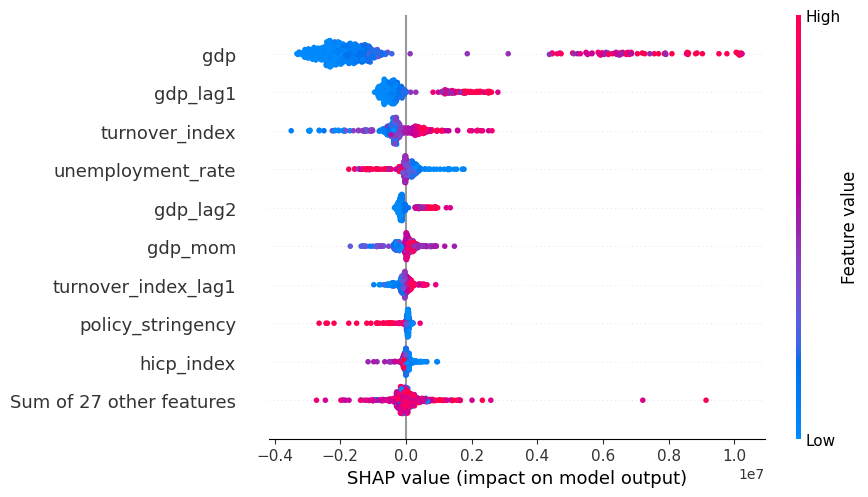

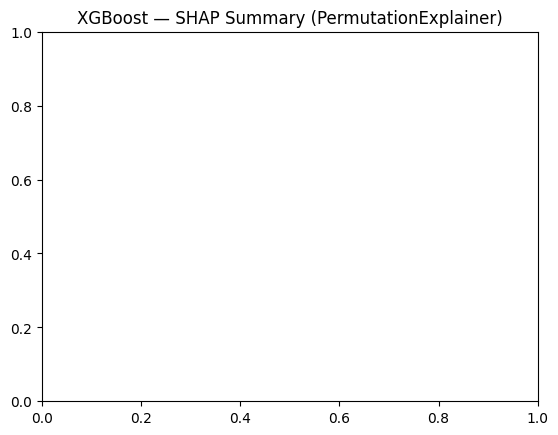

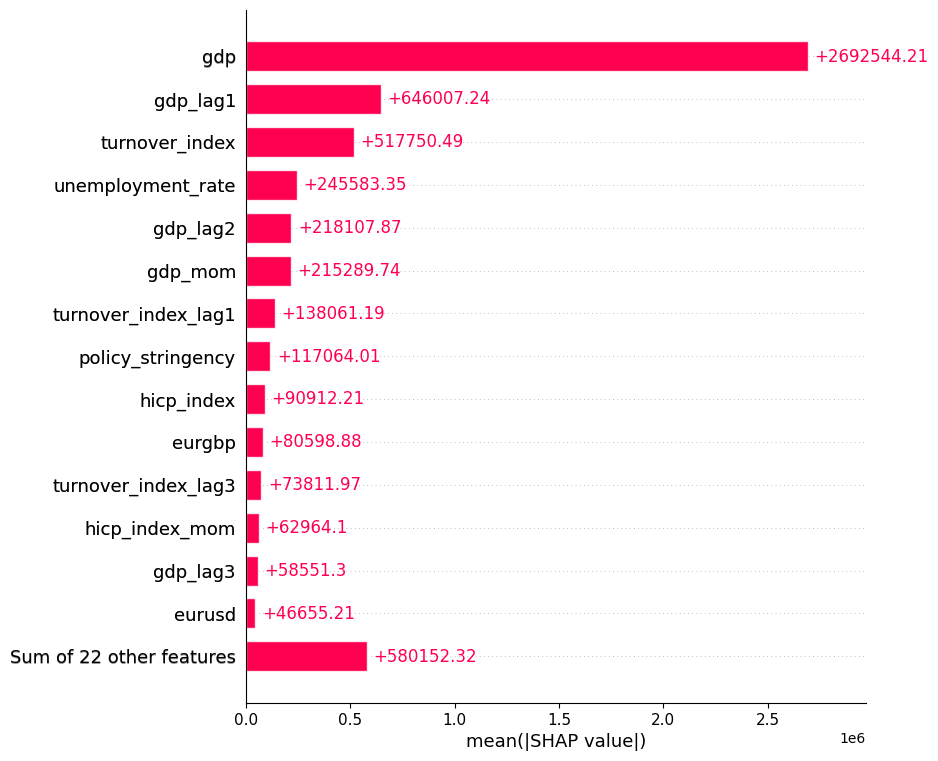

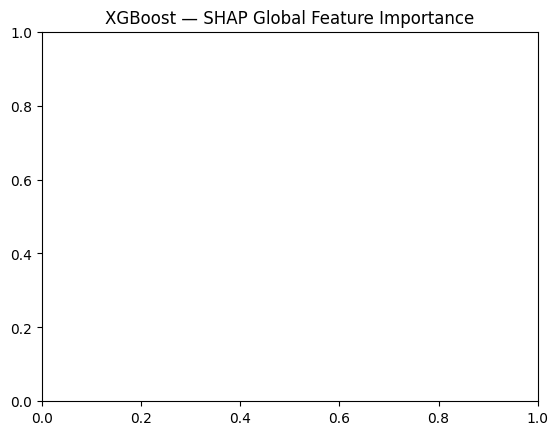

✅ SHAP plots generated and displayed


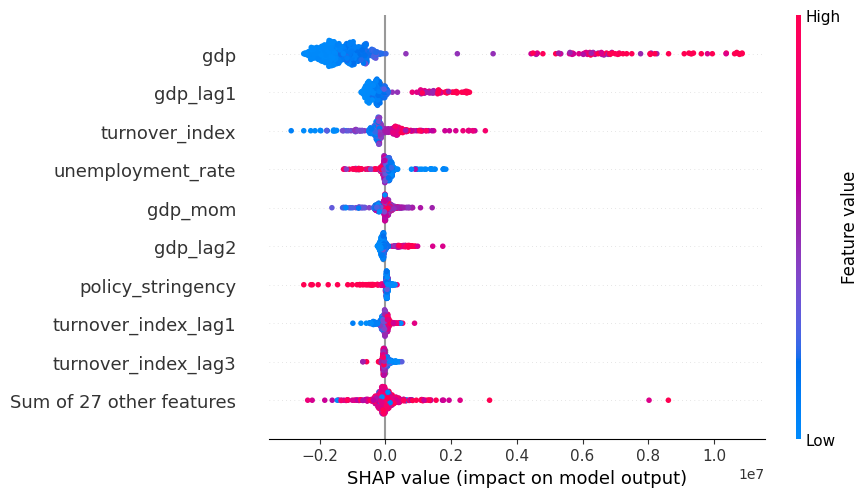

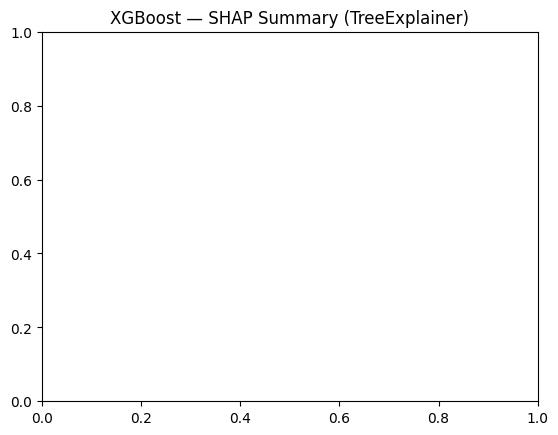

✅ TreeExplainer succeeded.


In [1]:
# ============================================================
# 🧠 XGBoost + SHAP Debug & Recovery Notebook
# ============================================================

import json
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt
from pathlib import Path
from xgboost import XGBRegressor

# ------------------------------------------------------------
# 1️⃣ Load processed data
# ------------------------------------------------------------
DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../outputs/models")

df = pd.read_csv(DATA_DIR / "hotel_panel_features.csv", parse_dates=["month"])
print(f"✅ Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# ------------------------------------------------------------
# 2️⃣ Prepare features and target
# ------------------------------------------------------------
y = df["nights_spent"]   # <-- target column
X = df.drop(columns=["nights_spent"])

# Drop non-numeric columns (e.g. region, month)
non_numeric = X.select_dtypes(exclude=["number", "bool"]).columns.tolist()
if non_numeric:
    print(f"⚙️ Dropping non-numeric columns: {non_numeric}")
    X = X.drop(columns=non_numeric)

# Convert all boolean columns to float
X = X.astype({c: "float64" for c in X.select_dtypes(include="bool").columns})

print("✅ Features ready for model training")
print(X.dtypes.value_counts())

# ------------------------------------------------------------
# 3️⃣ Train a clean XGBoost model
# ------------------------------------------------------------
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_model.fit(X, y)
print("✅ Clean XGBoost model retrained")

# ------------------------------------------------------------
# 4️⃣ Save the clean artifacts
# ------------------------------------------------------------
MODEL_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(xgb_model, MODEL_DIR / "xgb_model_clean.pkl")

X.to_parquet(MODEL_DIR / "X_train_shap_clean.parquet")
with open(MODEL_DIR / "X_train_shap_columns.json", "w") as f:
    json.dump(list(X.columns), f)
print("💾 Clean model + SHAP input matrix saved")

# ------------------------------------------------------------
# 5️⃣ Run SHAP (safe fallback mode)
# ------------------------------------------------------------
print("⚙️ Running SHAP PermutationExplainer (safe mode)...")
explainer = shap.Explainer(xgb_model.predict, X)
X_sample = X.sample(500, random_state=42)
shap_values = explainer(X_sample)

print("✅ SHAP values computed successfully")

# ------------------------------------------------------------
# 6️⃣ Visualize results
# ------------------------------------------------------------
plt.figure()
shap.plots.beeswarm(shap_values, max_display=10)
plt.title("XGBoost — SHAP Summary (PermutationExplainer)")
plt.show()

plt.figure()
shap.plots.bar(shap_values, max_display=15)
plt.title("XGBoost — SHAP Global Feature Importance")
plt.show()

print("✅ SHAP plots generated and displayed")

# ------------------------------------------------------------
# 7️⃣ Optional: Try TreeExplainer (after confirming stability)
# ------------------------------------------------------------
try:
    explainer_tree = shap.TreeExplainer(xgb_model)
    shap_values_tree = explainer_tree(X_sample)
    shap.plots.beeswarm(shap_values_tree, max_display=10)
    plt.title("XGBoost — SHAP Summary (TreeExplainer)")
    plt.show()
    print("✅ TreeExplainer succeeded.")
except Exception as e:
    print("⚠️ TreeExplainer failed, fallback to permutation mode:", e)

In [2]:
type(shap_values)

shap._explanation.Explanation

In [3]:
print("values shape:", shap_values.values.shape)
print("base values shape:", shap_values.base_values.shape)
print("data shape:", shap_values.data.shape)
print("feature names:", shap_values.feature_names[:10])

values shape: (500, 36)
base values shape: (500,)
data shape: (500, 36)
feature names: ['year', 'gdp_lag1', 'gdp_lag2', 'gdp_lag3', 'unemployment_rate_lag1', 'unemployment_rate_lag2', 'unemployment_rate_lag3', 'turnover_index_lag1', 'turnover_index_lag2', 'turnover_index_lag3']


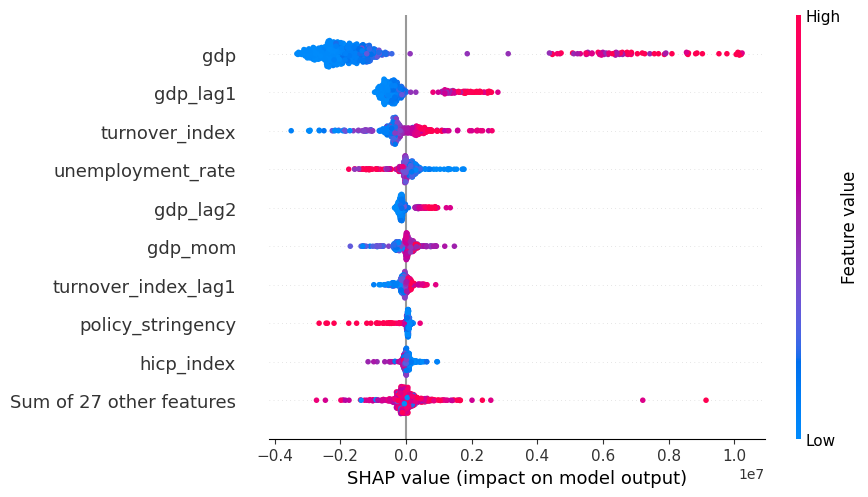

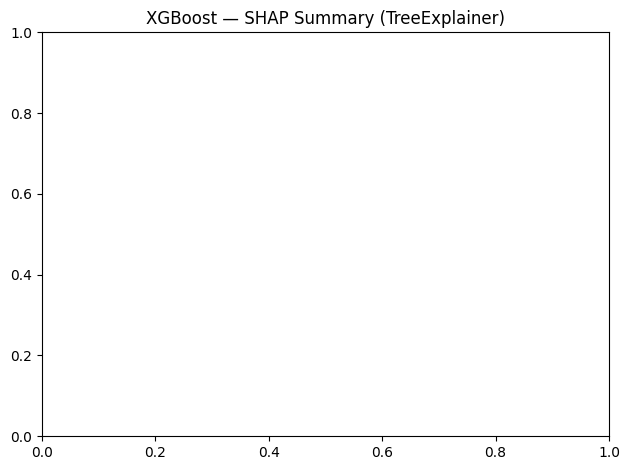

/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_81573/1263706739.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_values.feature_names, plot_type="bar", show=True)


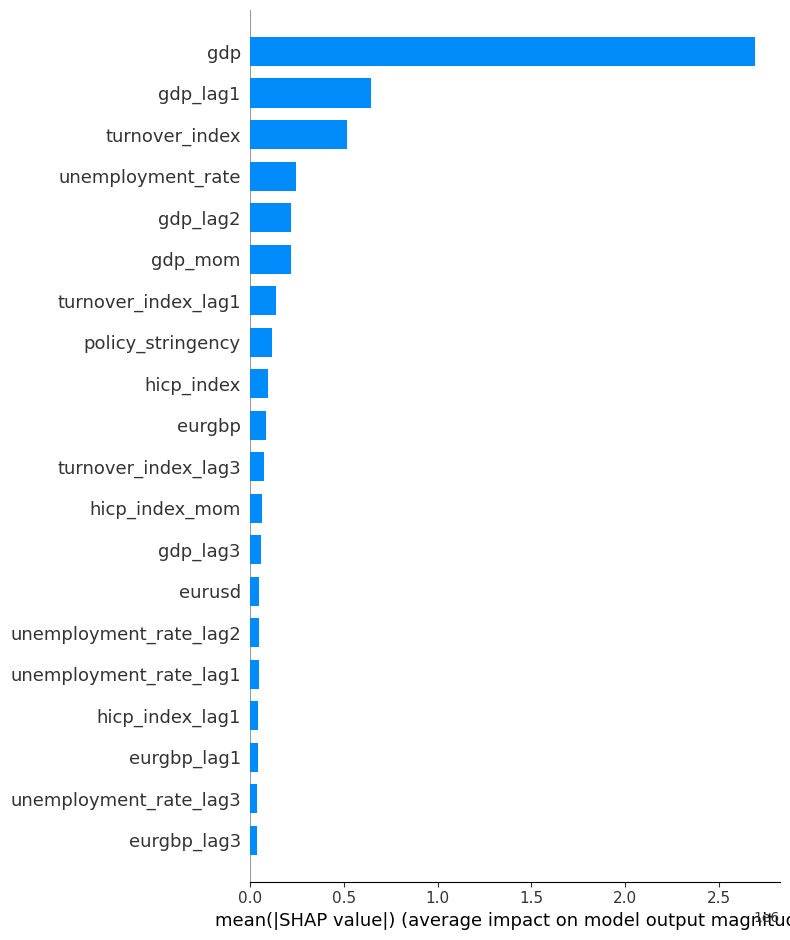

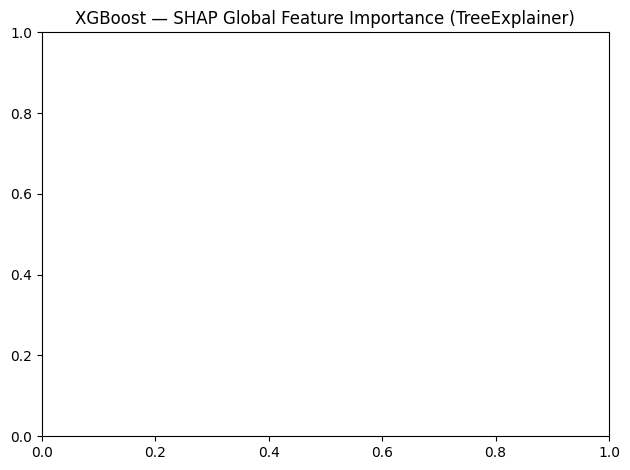

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import shap

# Force inline plotting for macOS/Jupyter
%matplotlib inline
matplotlib.use("module://matplotlib_inline.backend_inline")

# --- Beeswarm (feature-level impact)
plt.figure(figsize=(8,6))
shap.plots.beeswarm(shap_values, max_display=10)
plt.title("XGBoost — SHAP Summary (TreeExplainer)")
plt.tight_layout()
plt.show()

# --- Bar summary (global importance)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, shap_values.feature_names, plot_type="bar", show=True)
plt.title("XGBoost — SHAP Global Feature Importance (TreeExplainer)")
plt.tight_layout()
plt.show()

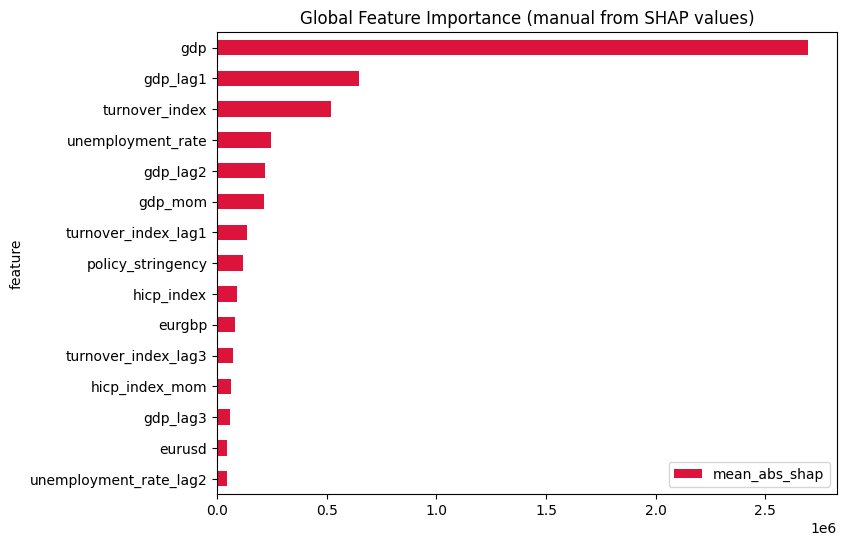

In [5]:
import numpy as np

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
importance = pd.DataFrame({
    "feature": shap_values.feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

importance.head(15).plot.barh(x="feature", y="mean_abs_shap", figsize=(8,6), color="crimson")
plt.title("Global Feature Importance (manual from SHAP values)")
plt.gca().invert_yaxis()
plt.show()

In [6]:
def plot_shap_summary(shap_values, X, max_display=15):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import shap

    try:
        shap.summary_plot(shap_values, X, max_display=max_display, plot_type="bar", show=True)
    except Exception as e:
        print(f"⚠️ SHAP bar plot failed ({e}). Falling back to manual rendering.")
        mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
        importance = pd.DataFrame({
            "feature": shap_values.feature_names,
            "mean_abs_shap": mean_abs_shap
        }).sort_values("mean_abs_shap", ascending=False)
        importance.head(max_display).plot.barh(
            x="feature", y="mean_abs_shap", figsize=(8,6), color="crimson"
        )
        plt.title("Global Feature Importance (manual from SHAP values)")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_81573/2273387560.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, max_display=max_display, plot_type="bar", show=True)


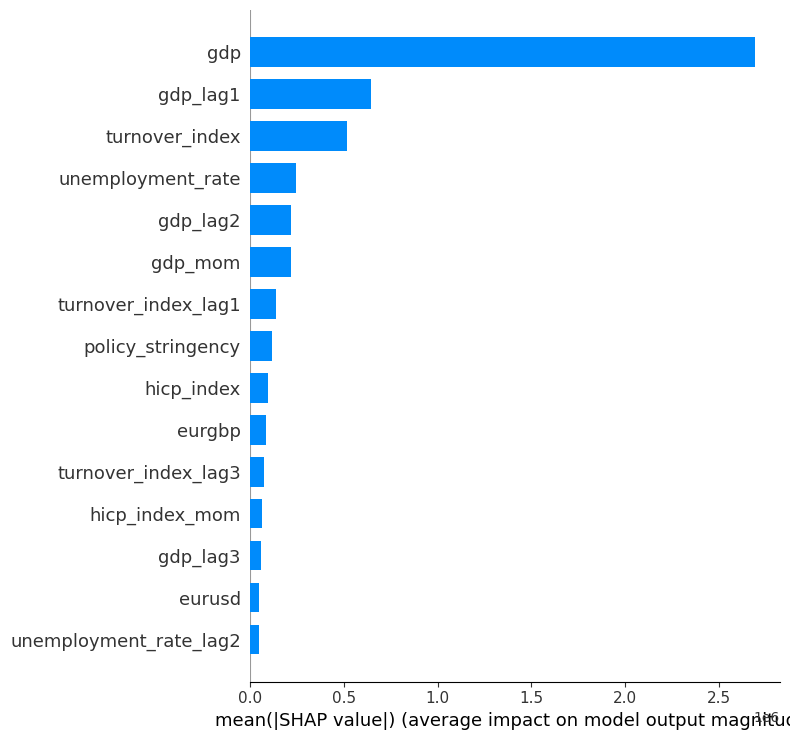

In [7]:
plot_shap_summary(shap_values, X)

In [ ]:
ggggggg

In [ ]:
import xgboost, shap
print("XGBoost version:", xgboost.__version__)
print("SHAP version:", shap.__version__)

In [ ]:
from xgboost import XGBRegressor
import joblib
from pathlib import Path

MODEL_DIR = Path("../outputs/models")

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_model.fit(X, y)

joblib.dump(xgb_model, MODEL_DIR / "xgb_model_clean.pkl")

booster = xgb_model.get_booster()
print("base_score:", booster.attr("base_score"))

In [ ]:
import shap

# --- Monkey-patch SHAP's XGBTreeModelLoader to handle bad base_score formats ---
from shap.explainers._tree import XGBTreeModelLoader, TreeExplainer

_orig_init = XGBTreeModelLoader.__init__

def _patched_init(self, xgb_model):
    _orig_init(self, xgb_model)
    try:
        val = getattr(self, "base_score", None)
        if isinstance(val, str) and val.startswith("[") and val.endswith("]"):
            cleaned = float(val.strip("[]"))
            print(f"🔧 Fixed base_score: {val} → {cleaned}")
            self.base_score = cleaned
    except Exception as e:
        print("⚠️ base_score patch failed:", e)

XGBTreeModelLoader.__init__ = _patched_init
print("✅ SHAP TreeExplainer patched for bad base_score")

In [ ]:
explainer_tree = shap.TreeExplainer(xgb_model)
shap_values_tree = explainer_tree(X_fixed.sample(500))
shap.plots.beeswarm(shap_values_tree, max_display=10)

In [ ]:
import json, tempfile

booster = xgb_model.get_booster()
with tempfile.NamedTemporaryFile(suffix=".json", mode="w+", delete=False) as f:
    booster.save_model(f.name)
    f.seek(0)
    model_json = json.load(f)

# Fix base_score manually
val = model_json["learner"]["learner_model_param"]["base_score"]
if isinstance(val, str) and val.startswith("["):
    model_json["learner"]["learner_model_param"]["base_score"] = val.strip("[]")
    print("🔧 Cleaned base_score")

# Save cleaned model
with open(f.name, "w") as f2:
    json.dump(model_json, f2)
booster.load_model(f.name)
xgb_model._Booster = booster

In [ ]:
# ============================================================
# 🧪 XGBoost SHAP Debug Notebook
# Purpose: isolate & fix numeric-string issue in SHAP input
# ============================================================

import pandas as pd
import joblib
import json
from pathlib import Path
from xgboost import XGBRegressor

# ------------------------------------------------------------
# 📂 Paths
# ------------------------------------------------------------
DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../outputs/models")

# ------------------------------------------------------------
# 📦 Load model + SHAP training matrix
# ------------------------------------------------------------
xgb_model = joblib.load(MODEL_DIR / "xgb_model.pkl")
X_train_matrix = pd.read_parquet(MODEL_DIR / "X_train_shap.parquet")

with open(MODEL_DIR / "X_train_columns.json") as f:
    train_cols = json.load(f)
X_train_matrix = X_train_matrix[train_cols].copy()

print("✅ Loaded model + SHAP input matrix")
print(f"Shape: {X_train_matrix.shape}")
print("Example columns:", list(X_train_matrix.columns)[:5])

In [ ]:
# ------------------------------------------------------------
# 🔍 Check for non-numeric or stringified numeric entries
# ------------------------------------------------------------
sample_rows = X_train_matrix.sample(5, random_state=0)
print("Sample values:\n", sample_rows.head())

bad_cols = [
    c for c in X_train_matrix.columns
    if X_train_matrix[c].astype(str).str.contains(r"\[|\]").any()
]
print(f"⚠️ Columns with stringified numbers: {bad_cols}")

print("Data types:")
print(X_train_matrix.dtypes.value_counts())

In [ ]:
# ------------------------------------------------------------
# 🧠 Inspect model booster attributes
# ------------------------------------------------------------
booster = xgb_model.get_booster()
attrs = booster.attributes()
print("Booster attributes:")
print(attrs)

# Quick JSON peek
import json
from tempfile import NamedTemporaryFile

with NamedTemporaryFile(mode="r+", suffix=".json", delete=False) as f:
    booster.save_model(f.name)
    f.seek(0)
    model_json = json.load(f)

# Find any "[...]" strings
def find_bracketed(obj, path=""):
    found = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            found += find_bracketed(v, f"{path}/{k}")
    elif isinstance(obj, list):
        for i, v in enumerate(obj):
            found += find_bracketed(v, f"{path}[{i}]")
    elif isinstance(obj, str) and obj.strip().startswith("[") and obj.strip().endswith("]"):
        found.append((path, obj))
    return found

issues = find_bracketed(model_json)
print(f"Found {len(issues)} bracketed-string entries:")
for p, v in issues:
    print(f" - {p}: {v}")

In [ ]:
# ============================================================
# 🧹 Fix bracketed base_score inside XGBoost model JSON
# ============================================================
import json
from tempfile import NamedTemporaryFile

booster = xgb_model.get_booster()

# Dump model JSON
with NamedTemporaryFile(mode="r+", suffix=".json", delete=False) as f:
    booster.save_model(f.name)
    f.seek(0)
    model_json = json.load(f)

# Locate and patch base_score
try:
    raw_val = model_json["learner"]["learner_model_param"]["base_score"]
    if isinstance(raw_val, str) and raw_val.startswith("[") and raw_val.endswith("]"):
        clean_val = raw_val.strip("[]")
        print(f"🔧 Fixing base_score: {raw_val} → {clean_val}")
        model_json["learner"]["learner_model_param"]["base_score"] = clean_val
    else:
        print("✅ base_score already clean:", raw_val)
except KeyError:
    print("⚠️ base_score not found — nothing to patch")

# Save & reload the cleaned model
with NamedTemporaryFile(mode="w+", suffix=".json", delete=False) as f2:
    json.dump(model_json, f2)
    f2.flush()
    booster.load_model(f2.name)

print("✅ Booster patched and reloaded successfully.")

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_train_matrix.sample(500, random_state=42))
shap.summary_plot(shap_values, X_train_matrix, max_display=10, plot_type="bar")

In [ ]:
import shap

# Save original constructor
_orig_init = shap.explainers._tree.XGBTreeModelLoader.__init__

def _patched_init(self, xgb_model):
    _orig_init(self, xgb_model)
    try:
        val = getattr(self, "base_score", None)
        if isinstance(val, str) and val.startswith("[") and val.endswith("]"):
            # strip brackets and coerce to float
            cleaned = float(val.strip("[]"))
            print(f"🔧 Patched SHAP loader base_score: {val} → {cleaned}")
            self.base_score = cleaned
    except Exception as e:
        print("⚠️ SHAP patch warning:", e)

# Apply patch
shap.explainers._tree.XGBTreeModelLoader.__init__ = _patched_init

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_train_matrix.sample(500, random_state=42))
shap.summary_plot(shap_values, X_train_matrix, max_display=10, plot_type="bar")

In [ ]:
import shap

# Model-agnostic fallback
explainer = shap.Explainer(xgb_model.predict, X_train_matrix)
shap_values = explainer(X_train_matrix.sample(500, random_state=42))
shap.plots.beeswarm(shap_values, max_display=10)

In [ ]:
from xgboost import XGBRegressor
import joblib, pandas as pd
from pathlib import Path

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../outputs/models")

X = pd.read_csv(DATA_DIR / "hotel_panel_features.csv")
y = X.pop("target_column")

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_model.fit(X, y)

joblib.dump(xgb_model, MODEL_DIR / "xgb_model.pkl")
print("✅ Clean model rebuilt and saved.")

In [ ]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data/processed")
df = pd.read_csv(DATA_DIR / "hotel_panel_features.csv")
print(df.columns.tolist())

In [ ]:
from xgboost import XGBRegressor
import joblib, pandas as pd
from pathlib import Path

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../outputs/models")

# Load dataset
X = pd.read_csv(DATA_DIR / "hotel_panel_features.csv")

# ✅ Target variable
y = X.pop("nights_spent")

# (Optional) Drop non-numeric or identifier columns if needed
if "region" in X.columns:
    X = pd.get_dummies(X, columns=["region"], drop_first=False)

if "month" in X.columns:
    # encode month if still datetime-like
    X["month"] = pd.to_datetime(X["month"], errors="coerce")

# Train a fresh XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_model.fit(X, y)

# Save the clean model
MODEL_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(xgb_model, MODEL_DIR / "xgb_model.pkl")

print("✅ Clean XGBoost model retrained and saved.")
print(f"Training matrix shape: {X.shape}")

In [ ]:
from xgboost import XGBRegressor
import joblib, pandas as pd
from pathlib import Path

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../outputs/models")

# ------------------------------------------------------------
# 📂 Load dataset
# ------------------------------------------------------------
X = pd.read_csv(DATA_DIR / "hotel_panel_features.csv")

# ✅ Target variable
y = X.pop("nights_spent")

# ------------------------------------------------------------
# 🧹 Feature cleanup
# ------------------------------------------------------------

# Convert region to dummy variables
if "region" in X.columns:
    X = pd.get_dummies(X, columns=["region"], drop_first=False)

# Convert month → numeric (e.g., extract month number)
if pd.api.types.is_datetime64_any_dtype(X["month"]):
    X["month"] = X["month"].dt.month
else:
    # If month is still string, try to parse and extract numeric month
    try:
        X["month"] = pd.to_datetime(X["month"], errors="coerce").dt.month
    except Exception:
        X["month"] = X["month"].astype(str).str.extract(r"(\d+)").astype(float)

# ------------------------------------------------------------
# 🚀 Train clean XGBoost model
# ------------------------------------------------------------
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_model.fit(X, y)

# ------------------------------------------------------------
# 💾 Save model
# ------------------------------------------------------------
MODEL_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(xgb_model, MODEL_DIR / "xgb_model.pkl")

print("✅ Clean XGBoost model retrained and saved.")
print(f"Training matrix shape: {X.shape}")
print("Example columns:", list(X.columns)[:5])

In [ ]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X.sample(500, random_state=42))
shap.summary_plot(shap_values, X, max_display=10, plot_type="bar")

In [ ]:
import shap

explainer = shap.Explainer(xgb_model.predict, X)
shap_values = explainer(X.sample(500, random_state=42))
shap.plots.beeswarm(shap_values, max_display=10)

In [ ]:
X.dtypes.value_counts()

In [ ]:
X_fixed = X.astype({c: "float64" for c in X.select_dtypes(include="bool").columns})


In [ ]:
X_fixed = X.copy()
X_fixed = X_fixed.astype(float)

In [ ]:
import shap

explainer = shap.Explainer(xgb_model.predict, X_fixed)
X_sample = X_fixed.sample(500, random_state=42)

shap_values = explainer(X_sample)
shap.plots.beeswarm(shap_values, max_display=10)

In [ ]:
import joblib, pandas as pd
from pathlib import Path

MODEL_DIR = Path("../outputs/models")
DATA_DIR = Path("../data/processed")

# Save the clean matrix used for SHAP
X_fixed.to_parquet(MODEL_DIR / "X_train_shap_clean.parquet")
X_fixed.columns.to_series().to_json(MODEL_DIR / "X_train_shap_columns.json")

# Save the model again (clean, retrained)
joblib.dump(xgb_model, MODEL_DIR / "xgb_model_clean.pkl")

print("✅ Clean model + matrix frozen.")

In [ ]:
preds = xgb_model.predict(X_fixed)
print(preds.min(), preds.max(), preds.mean())

In [ ]:
shap.plots.bar(shap_values, max_display=15)

In [ ]:
shap.plots.scatter(shap_values[:, "gdp"], color=shap_values[:, "gdp_lag1"])
shap.plots.scatter(shap_values[:, "policy_stringency"], color=shap_values[:, "month"])

In [ ]:
explainer_tree = shap.TreeExplainer(xgb_model)
shap_values_tree = explainer_tree(X_fixed.sample(500))
shap.plots.beeswarm(shap_values_tree, max_display=10)